# Introduction

Is it better to draw capital gains from a market ETF (Exchange Traded Fund) or use a monthly income ETF? 
Also, which ETFs provide monthly income yet still appreciate over time? 
These are questions on the mind of many investors, especially those who are retired and are 
counting on the income generated from their portfolio. 
The purpose of this report is to answer these questions.

Every investor is looking for yield, and there are many ETFs that provide a monthly dividend. 
Some of these dividends however seem too good to be true, and they are. If the dividends paid by an ETF are
greater than the dividends of the funds held then the yield is partly made up of "return of capital". 

Would a Canadian investor who needs monthly income be better off buying an ETF that pays a high dividend, or 
would he or she be better off buying a market ETF and selling shares to obtain the income? In order to find 
out I will compare six of the most popular ETFs in Canada. I'll draw the same amount from each fund each year
and see how much of the fund remains after a ten year period.

# Methods

Python will be used to compare the ETFs. The closing price and dividends for each of these stocks was obtained with the Yahoo Finance API. I've written some functions to buy stock if the dividend exceeds 
our income needs, and sell stock if it falls short.

First I will start with some typical analysis. I will look at the price changes over time, the volatility, 
and how well these ETFs correlate to each other.

## Stocks

The following table shows the stocks used in this analysis. They include the perennial favorite XIU, which 
is the first and largest Canadian ETF, and CDZ, the Canadian Dividend Aristocrats Index, an ETF made up
of a diversified group of high quality Canadian dividend companies.

In [811]:
# Import libraries
from pandas_datareader import data as wb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
%matplotlib inline

In [812]:
import warnings
warnings.filterwarnings('ignore')

In [813]:
# Start here - check these tickers
tickers = ['XIU.TO','CDZ.TO','XDV.TO','XTR.TO','ZEB.TO','FIE.TO']
# Years of interest
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2020']

In [814]:
#Pull in yahoo finance data
new_data = pd.DataFrame()
for t in tickers:
    new_data[t] = wb.DataReader(t, data_source='yahoo', start='2011-1-1')['Close']

In [815]:
new_data['trade_year'] = new_data.index.map(str).str.slice(0, 4)

# Results

## Visualization

Let's visualize these ETFs to see how they compare with regards to return, price changes, volatility and correlation.

### Time Series

<br>

Let's take a look at how the prices have changed for these stocks over the last decade. 
The graph below shows a similar pattern among 4 of the stocks. FIE and XTR are the outliers with what seem
like much less of an increase in price over the decade. This makes sense as a large part of these 
two ETFs are made up of bonds and preferred shares.

ZEB seems to be the clear winner. The similar pattern in the top 4 stocks makes sense as there's
obviously overlap among them. ZEB is an equal weighted index of Canadian banks, and XIU and other 
dividend stocks will of course include Canadian banks, which are favorites among dividend income
seekers.



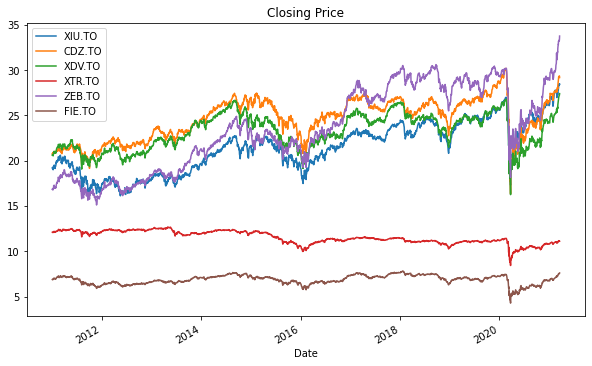

In [816]:
for t in tickers:
    new_data[t].plot(legend=True, figsize=(10, 6), \
    title='Closing Price', \
    label=t)

The stock prices vary tremendously, for example CDZ is well over \$30 a share and FIE is about \$7 
at the time this was written it makes sense to normalize all the prices to 100. This will make it easier
to compare the price changes over time. 

$$
\frac{P_t}{P_0} * 100
$$

The normalized plot below further emphasizes how well ZEB, BMO's equally weighted bank index, has done
over the last decade.

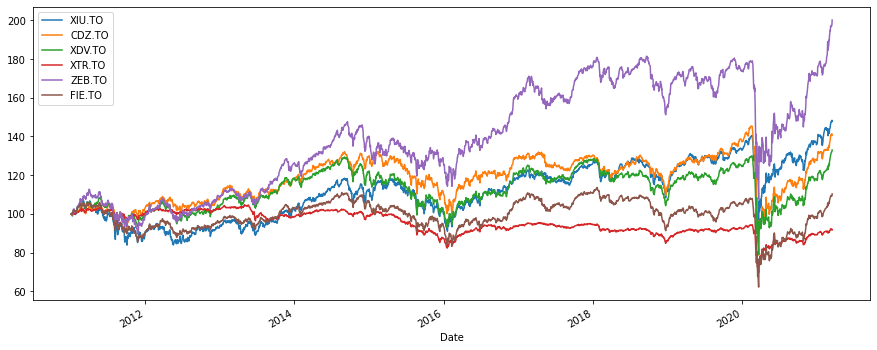

In [817]:
# We have to exclude the trade_year column as this is a string.
df_no_date = new_data.iloc[:,0:6]

# Now we normalize the data
(df_no_date.iloc[:,0:6] / df_no_date.iloc[0] * 100).plot(figsize = (15, 6));
plt.show()

### Returns by Year


In [826]:
new_data.index = new_data.index.map(str)

# Add a date column
new_data['trade_year'] = new_data.index.str.slice(0, 4)

# Prevent warning when writing back to object
pd.options.mode.chained_assignment = None  # default='warn'

# A list used to keep the stock return data
values = []

# Loop through each year and the each ticker and find the last day and the first day
# of the year to calculate the return
for y in years:
    for t in tickers:
        # We can use iloc to find the last value and the first value
        rate_return = new_data[new_data['trade_year'] == y].iloc[-1][t] / \
        new_data[new_data['trade_year'] == y].iloc[0][t] - 1
        values.append([t, y, rate_return])
    

# Create the DataFrame from the list
values_df = pd.DataFrame(values)  
# Rename the DataFrame columns
values_df.columns = ['ticker','trade_year','yr_return']
# Sort the DataFrame
values_df.sort_values(by=['ticker','trade_year'], inplace=True)
# Format the value of the yr_return column
values_df['yr_return'] = round(values_df.yr_return,4) * 100

# Make the index just the date instead of the datetime
new_data.index = new_data.index.str.slice(0,10)

The following figure shows the returns for each of the ETFs by year. 
There have been three or four down years for each of the funds in the last decade. 

ZEB has had a couple of stellar years.

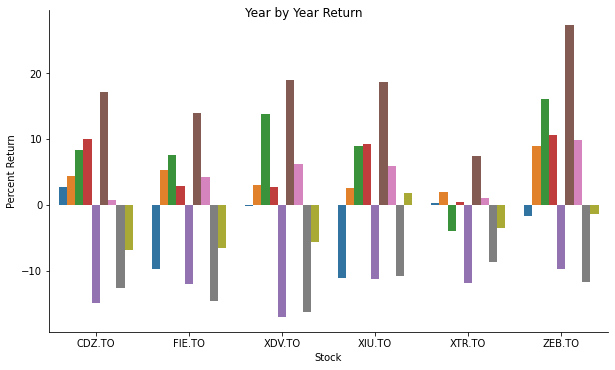

In [827]:
values_df

g = sns.catplot(x='ticker', y='yr_return', hue='trade_year', data=values_df, kind='bar', legend=False)
g.fig.set_figwidth(9)
g.fig.suptitle("Year by Year Return")
g.set_axis_labels("Stock", "Percent Return");

### Volatility

The following plots show the distributions of the prices for each of these tickers over the decade.
XTR shows the least amount of volatility. This makes sense due to its high bond component. 

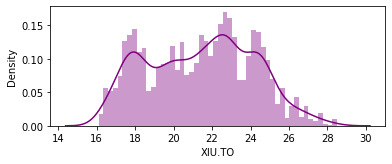

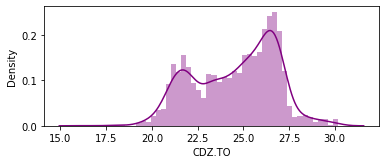

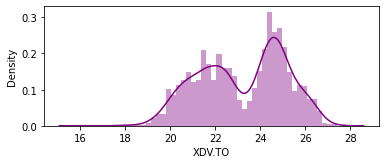

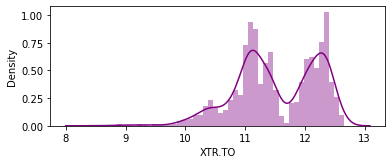

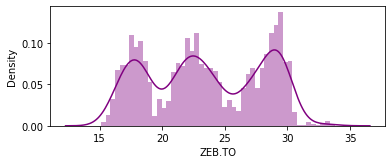

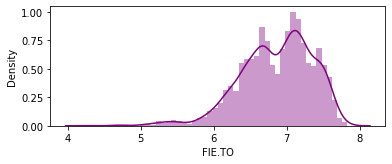

In [828]:
for t in tickers:
    plt.figure(figsize=(6,2.2))
    #fig, axs = plt.subplots(2, 3)
    sns.distplot(new_data[t].dropna(), bins=50, color='purple');

### Correlations

The heatmap below shows how correlated the ETFs are. 
It's no surprise that the pure stock ETFs are highly correlated.

CDZ and XDV are highly correlated (94%). This is understandable as they both hold the major banks.
Again XTR is the outlier here as it includes some US stock and it's weighted about 50/50 between
stocks and bonds.

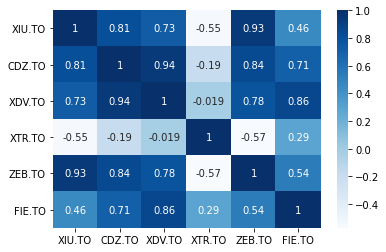

In [829]:
# Calculate correlations
corr = new_data[tickers].corr()
# Heatmap
sns.heatmap(corr, cmap = "Blues", annot=True);

## Income - Which is Best?

To answer the question of which ETF is the most valuable after a decade of providing income 
we need to create a dataframe of the start and end closing prices for each stock, and the sum of 
all the dividends provided for each year. 

The following code creates such a dataframe using data 
accessed from Yahoo Finance's API.

### Feature Engineering

In [830]:
# Let's create a table for the yearly data
dfReturns = pd.DataFrame({"Year" :[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]})

In [831]:
#new_data['Date']= pd.to_datetime(new_data['Date'])
new_data.index = pd.to_datetime(new_data.index)

### Retrieve Dividend Data

In [832]:
# Yahoo finance app
import yfinance as yf

In [833]:
# bring in the data
cdz = yf.Ticker("CDZ.TO")
xiu = yf.Ticker("XIU.TO")
xdv = yf.Ticker("XDV.TO")
xtr = yf.Ticker("XTR.TO")
zeb = yf.Ticker("ZEB.TO")
fie = yf.Ticker("FIE.TO")

In [834]:
# Create an 11 year period
CDZ_hist = cdz.history(period="11y")
XIU_hist = xiu.history(period="11y")
XDV_hist = xdv.history(period="11y")
XTR_hist = cdz.history(period="11y")
ZEB_hist = zeb.history(period="11y")
FIE_hist = fie.history(period="11y")


### Join Tables

In [835]:
# Add the dividend data for each stock to the main table
new_data = new_data.join(CDZ_hist[['Dividends']])
new_data.rename(columns={'Dividends': 'CDZ.TO.DIV'}, inplace=True)

new_data = new_data.join(XIU_hist[['Dividends']])
new_data.rename(columns={'Dividends': 'XIU.TO.DIV'}, inplace=True)

new_data = new_data.join(XDV_hist[['Dividends']])
new_data.rename(columns={'Dividends': 'XDV.TO.DIV'}, inplace=True)

new_data = new_data.join(XTR_hist[['Dividends']])
new_data.rename(columns={'Dividends': 'XTR.TO.DIV'}, inplace=True)

new_data = new_data.join(ZEB_hist[['Dividends']])
new_data.rename(columns={'Dividends': 'ZEB.TO.DIV'}, inplace=True)

new_data = new_data.join(FIE_hist[['Dividends']])
new_data.rename(columns={'Dividends': 'FIE.TO.DIV'}, inplace=True)

In [836]:
new_data.reset_index(level=0, inplace=True)

### Function to rollup columns

In [837]:
# Function to add columns to dfReturns - 
def Add_Columns(df, col_name):
    min_indices = df.groupby('trade_year')['Date'].idxmin()
    dfReturns[col_name+"_start"] = list(df.loc[min_indices][col_name])
    max_indices = df.groupby('trade_year')['Date'].idxmax()
    dfReturns[col_name+"_end"] = list(df.loc[max_indices][col_name])
    dfReturns[col_name+"_div"] = list(df[["trade_year",col_name+".DIV"]].\
                                      groupby("trade_year").sum()[col_name+".DIV"])

In [838]:
Add_Columns(new_data,"CDZ.TO")
Add_Columns(new_data,"XIU.TO")
Add_Columns(new_data,"XDV.TO")
Add_Columns(new_data,"XTR.TO")
Add_Columns(new_data,"ZEB.TO")
Add_Columns(new_data,"FIE.TO")

In [839]:
#dfReturns.iloc[0:3,0:4]

### Table for Analysis

The final result is a table that shows the start and end closing prices, and total dividends paid 
for each stock for each year.

Here are the first couple rows for the CDZ columns: 


### Calculate Net Worth after Income Draw

Now we are ready to ready to test each scenario.

**Here are the rules:**

* At the beginning of the first year buy \$1,000,000 of stock.


* Draw \$40,000 in income from each stock at the end of each 
year.$\footnote{We will consider this year to have ended today}$

* If the dividends pay more than \$40,000 reinvest the remainder, if they pay less, sell shares to make up the difference.

* Let's see what is remaining for each stock.

The following function will do these calculations.

In [840]:
def calcRemain(stock_name):
    # variables
    initial_amt = 1_000_000
    year_income = 40_000
    
    result = [(y,s,e,d) for y,s,e,d in zip(dfReturns['Year'], dfReturns[stock_name+'_start'], \
                                     dfReturns[stock_name+'_end'],dfReturns[stock_name+'_div'])]
    
    initial_price = result[0][1]
    no_shares = mt.trunc(initial_amt/initial_price)

    for row in result:
        div_income = no_shares * row[3]
        
        if div_income > year_income:
            end_price = row[2]
            buy_shares = mt.trunc((div_income - year_income)/end_price)
            no_shares = no_shares + buy_shares
            
        else:
            end_price = row[2]
            sell_shares = mt.trunc((year_income - div_income)/end_price)
            no_shares = no_shares - sell_shares
            
    final_amt = result[-1][2] * no_shares
    return(final_amt)

Let's apply the function to each of the stocks.


In [841]:
stock_list = []
stock_list.append(mt.trunc(calcRemain('CDZ.TO')))
stock_list.append(mt.trunc(calcRemain('XIU.TO')))
stock_list.append(mt.trunc(calcRemain('XDV.TO')))
stock_list.append(mt.trunc(calcRemain('XTR.TO')))
stock_list.append(mt.trunc(calcRemain('ZEB.TO')))
stock_list.append(mt.trunc(calcRemain('FIE.TO')))

In [842]:
dfRemains = pd.DataFrame(stock_list, index =['CDZ', 'XIU', 'XDV', 'XTR','ZEB','FIE'], 
                                              columns =['Remaining']) 

In [843]:
dfRemains.sort_values(by=['Remaining'], ascending=False).style.format('${0:,.2f}')

,Remaining
ZEB,"$2,090,278.00"
FIE,"$1,531,453.00"
CDZ,"$1,424,713.00"
XTR,"$1,409,892.00"
XDV,"$1,404,578.00"
XIU,"$1,293,365.00"


### And The Winner is:


The following table shows the remaining funds had we invested \$1,000,000 in each of these stocks
and withdrew \$40,000 in income each year. 


<br>
There's a large difference in each of the ETFs. ZEB, BMO's Equal Weighted Bank Stock ETF is the clear winner. If we had invested \$1,000,000 ten years ago in ZEB and withdrew \$40,000 each year we would now have over \$2,000,000 in the fund. Remarkable. It seems that Banks ruled, at least for the last decade. 

The remaining funds are relatively close. The difference between the growth of FIE, the second ranked fund,
and XIU the worst fund, is only \$230,000. With every fund examined it was possible to take \$40,000 in income
each year and still keep all of your principle. 

# Conclusions

It seems it was the decade of Canadian bank stocks. We were able to draw a healthy income from ZEB and also
more than double our investment. It's important to note that the last decade's results may not continue into
the next ten years. We faced a time when interest rates have steadily fallen, Canadian stocks have 
underperformed their American counterparts, and growth of the tech sector has been phenomenal. It's likely
that the macro conditions that brought about these results won't continue into future decades.

However Canadian banks have been incredibly robust over many years. It's amazing to think that BMO, Scotiabank,
Toronto Dominion, CIBC and The Royal Bank have been consistently paying dividends for over 100 years! In fact
the Bank of Nova Scotia and The Bank of Montreal have almost been paying for 200 years. Our banks have a
history of stability, regulatory prudence, and consistency that is admirable.

Its also important to remember that there are tax considerations for the types of income one receives from 
stock. Income from dividend stocks such as CDZ, XDV and ZEB are eligible for a dividend tax credit. 
Over 90% of the distributions from these ETFs are **eligible dividends**. That's not true for many income
funds - for XTR it's only about 25%. Consider that you can make over \$50,000 in income each year 
from dividends and you won't pay a cent in tax, provided it's your only source of income.$\footnote{Financial Post, April 11th, 2017, "You can earn \$50K in tax-free dividends, but there's a catch: You can't have a job"}$

We cannot know the future, but it would probably be a good bet to invest in Canadian bank stocks if one
wanted consistent monthly income with long term growth of capital.


In [846]:
dfReturns.to_csv('dfReturns.csv')